# スクレイピング

In [2]:
import requests
from bs4 import BeautifulSoup
import time
import sqlite3
import re  # 数字抽出用のライブラリ

# 初期設定
base_url = "https://www.jalan.net/theme/ski/"
query_base = "?roomCount=1&"
query_mid = "&adultNum=2&distCd=05&stayYear=&stayMonth=&dateUndecided=1&roomCrack=200000&vosFlg=6&mvTabFlg=1&stayDay=&screenId=UWW1402&activeSort=0&stayCount=1&rootCd=01126195&"

pref_codes = {
    "北海道": 126179,
    "青森": 126180,
    "岩手": 126181,
    "宮城": 126182,
    "秋田": 126183,
    "山形": 126184,
    "福島": 126185,
    "栃木": 126186,
    "群馬": 126187,
    "茨城": 126188,
    "埼玉": 126189,
    "千葉": 126190,
    "東京": 126191,
    "神奈川": 126192,
    "山梨": 126193,
    "長野": 126194,
    "新潟": 126195,
    "富山": 126196,
    "石川": 126197,
    "福井": 126198,
    "静岡": 126199,
    "岐阜": 126200,
    "愛知": 126201,
    "三重": 126202,
    "滋賀": 126203,
    "京都": 126204,
    "大阪": 126205,
    "兵庫": 126206,
    "奈良": 126207,
    "和歌山": 126208,
    "鳥取": 126209,
    "島根": 126210,
    "岡山": 126211,
    "広島": 126212,
    "山口": 126213,
    "徳島": 126214,
    "香川": 126215,
    "愛媛": 126216,
    "高知": 126217,
    "福岡": 126218,
    "佐賀": 126219,
    "長崎": 126220,
    "熊本": 126221,
    "大分": 126222,
    "宮崎": 126223,
    "鹿児島": 126224,
    "沖縄": 126225,
}

# 結果を保存するリスト
results = []

# データベースの設定
create_table_sql = """
CREATE TABLE IF NOT EXISTS hotels (
    hotel_name TEXT,
    price INTEGER,
    rating TEXT,
    highly_rated TEXT,
    pref TEXT  -- 都道府県名を保存するカラムを追加
)
"""

# データベースに接続
conn = sqlite3.connect("jalan_hotels.db")
c = conn.cursor()

# テーブルが存在する場合は削除
c.execute("DROP TABLE IF EXISTS hotels")
print("既存のテーブルを削除しました。")

# テーブルを作成
c.execute(create_table_sql)
print("新しいテーブルを作成しました。")

# 都道府県ごとにスクレイピング
for pref, ssc in pref_codes.items():
    print(f"{pref} のデータ取得を開始します...")
    
    # ページカウントとインデックスを都道府県ごとにリセット
    page_count = 0
    idx = 0
    pref_results = []  # 各都道府県の結果を保存するリスト

    while True:
        # URLを構築
        full_url = f"{base_url}{query_base}ssc={ssc}{query_mid}idx={idx}"
        print(f"取得中: {pref}: {full_url}")

        # ページを取得
        response = requests.get(full_url)

        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')

            # 宿泊施設データを取得
            items = soup.select('.p-yadoCassette__summary')  # 宿泊施設のリストを取得
            if not items:
                break  # データがない場合、ループを終了

            for item in items:
                hotel_name_tag = item.select_one('.p-searchResultItem__facilityName')
                price_tag = item.select_one('.p-searchResultItem__lowestPriceValue')
                rating_tag = item.select_one('.p-searchResultItem__summaryaverage-num')
                highly_rated_tag = item.select_one('.p-searchResultItem__highlyRated strong')

                hotel_name = hotel_name_tag.text.strip() if hotel_name_tag else ""
                
                price = price_tag.text.strip() if price_tag else ""
                price = re.sub(r'[^\d]', '', price)  # 数字以外の文字を削除

                # 数値が存在する場合は 1/2 の値を取得
                price = int(price) // 2 if price else 0


                rating = rating_tag.text.strip() if rating_tag else ""
                highly_rated = highly_rated_tag.text.strip() if highly_rated_tag else ""

                # 都道府県名を追加
                pref_results.append({
                    "hotel_name": hotel_name,
                    "price": price if price else None,  # priceがない場合はNone
                    "rating": rating,
                    "highly_rated": highly_rated,
                    "pref": pref  # 都道府県名を追加
                })

            # 次のインデックスを更新
            idx += 30  # 1ページ30件

            # データ数が少ない場合はループを抜ける（ページの最終ページに到達）
            if len(items) < 30:
                break

            page_count += 1
            print(f"ページ {page_count} を取得しました。")
            time.sleep(1)  # サーバー負荷軽減のため1秒待機
        else:
            print(f"{pref} のページ {page_count + 1} の取得に失敗しました。")
            break
    
    # 各都道府県ごとのデータ件数を表示
    print(f"{pref} のデータ取得完了: {len(pref_results)} 件")

    # データを全体の結果に追加
    results.extend(pref_results)

# データベースに保存
insert_sql = "INSERT INTO hotels (hotel_name, price, rating, highly_rated, pref) VALUES (?, ?, ?, ?, ?)"
for result in results:
    c.execute(insert_sql, (result['hotel_name'], result['price'], result['rating'], result['highly_rated'], result['pref']))

# コミットしてクローズ
conn.commit()
conn.close()
print("新しいデータをデータベースに保存しました。")


既存のテーブルを削除しました。
新しいテーブルを作成しました。
北海道 のデータ取得を開始します...
取得中: 北海道: https://www.jalan.net/theme/ski/?roomCount=1&ssc=126179&adultNum=2&distCd=05&stayYear=&stayMonth=&dateUndecided=1&roomCrack=200000&vosFlg=6&mvTabFlg=1&stayDay=&screenId=UWW1402&activeSort=0&stayCount=1&rootCd=01126195&idx=0
ページ 1 を取得しました。
取得中: 北海道: https://www.jalan.net/theme/ski/?roomCount=1&ssc=126179&adultNum=2&distCd=05&stayYear=&stayMonth=&dateUndecided=1&roomCrack=200000&vosFlg=6&mvTabFlg=1&stayDay=&screenId=UWW1402&activeSort=0&stayCount=1&rootCd=01126195&idx=30
ページ 2 を取得しました。
取得中: 北海道: https://www.jalan.net/theme/ski/?roomCount=1&ssc=126179&adultNum=2&distCd=05&stayYear=&stayMonth=&dateUndecided=1&roomCrack=200000&vosFlg=6&mvTabFlg=1&stayDay=&screenId=UWW1402&activeSort=0&stayCount=1&rootCd=01126195&idx=60
北海道 のデータ取得完了: 83 件
青森 のデータ取得を開始します...
取得中: 青森: https://www.jalan.net/theme/ski/?roomCount=1&ssc=126180&adultNum=2&distCd=05&stayYear=&stayMonth=&dateUndecided=1&roomCrack=200000&vosFlg=6&mvTabFlg=1&stayDay=&screenI

# 分析

## 1.価格に基づく分析

#### a. 価格の分布を可視化

In [15]:
import japanize_matplotlib
import os

import warnings
warnings.filterwarnings("ignore")  # 警告を非表示

# 他の処理をここに記述


# データベースファイル名（例えば "jalan_hotels.db"）
db_file = "jalan_hotels.db"

# 絶対パスを取得
db_path = os.path.abspath(db_file)
print(f"使用するデータベースパス: {db_path}")

# SQLite に接続
conn = sqlite3.connect(db_path)


使用するデータベースパス: /Users/hatakeyamaitsuki/dsprog2/trip/jalan_hotels.db


Note: you may need to restart the kernel to use updated packages.


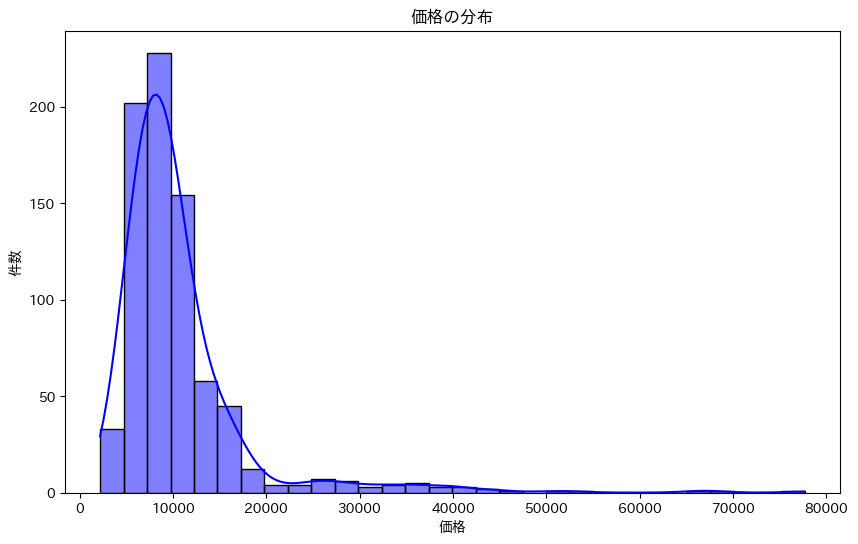

Shapiro-Wilk 検定: W=0.630, p=0.000
価格の分布は正規分布に従っていない可能性があります。


In [ ]:
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro

# Install matplotlib if not already installed
%pip install matplotlib

import matplotlib.pyplot as plt

# データを読み込み
conn = sqlite3.connect("/Users/hatakeyamaitsuki/dsprog2/trip/jalan_hotels.db")
df = pd.read_sql_query("SELECT * FROM hotels", conn)
conn.close()

# 価格の分布可視化
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True, bins=30, color='blue', edgecolor='black')
plt.title("価格の分布")
plt.xlabel("価格")
plt.ylabel("件数")
plt.show()

# 正規性検定
stat, p_value = shapiro(df['price'])
print(f"Shapiro-Wilk 検定: W={stat:.3f}, p={p_value:.3f}")
if p_value > 0.05:
    print("価格の分布は正規分布に従っている可能性があります。")
else:
    print("価格の分布は正規分布に従っていない可能性があります。")


#### b. 価格の平均値の比較

ANOVA 検定: F=4.548, p=0.000
少なくとも1つの都道府県で平均価格が異なります。


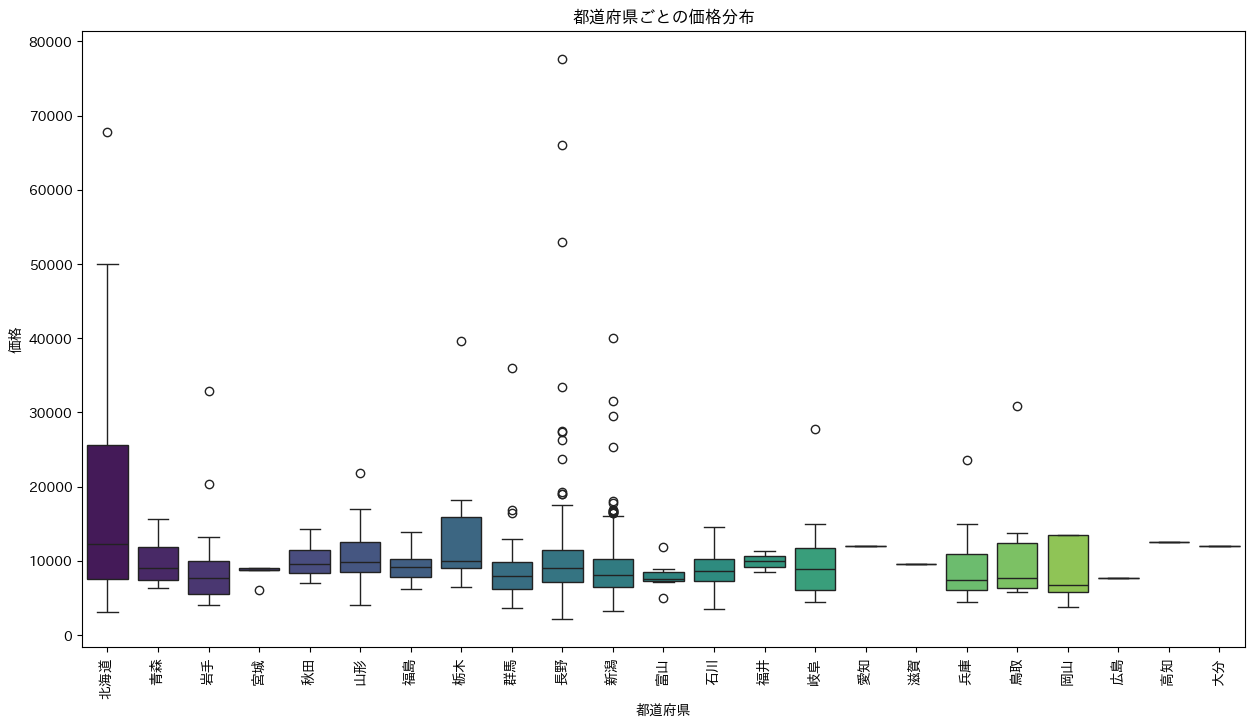

In [16]:
from scipy.stats import f_oneway

# 都道府県別に価格の平均を比較
pref_prices = [df[df['pref'] == pref]['price'] for pref in df['pref'].unique()]
stat, p_value = f_oneway(*pref_prices)
print(f"ANOVA 検定: F={stat:.3f}, p={p_value:.3f}")
if p_value < 0.05:
    print("少なくとも1つの都道府県で平均価格が異なります。")

# グラフ
plt.figure(figsize=(15, 8))
sns.boxplot(data=df, x='pref', y='price', palette='viridis')
plt.xticks(rotation=90)
plt.title("都道府県ごとの価格分布")
plt.xlabel("都道府県")
plt.ylabel("価格")
plt.show()


#### c. 高価格 vs 低価格の特性比較

In [21]:
print(df.dtypes)

# price のクリーニングと変換
df['price'] = pd.to_numeric(df['price'], errors='coerce')  # 数値に変換できない値を NaN にする

# rating のクリーニングと変換
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')  # 数値に変換できない値を NaN にする

# NaN を含む行を削除（必要に応じて）
df = df.dropna(subset=['price', 'rating'])


hotel_name      object
price            int64
rating          object
highly_rated    object
pref            object
dtype: object


マン・ホイットニーU検定: U=13956.500, p=0.000
高価格と低価格の評価に有意差があります。


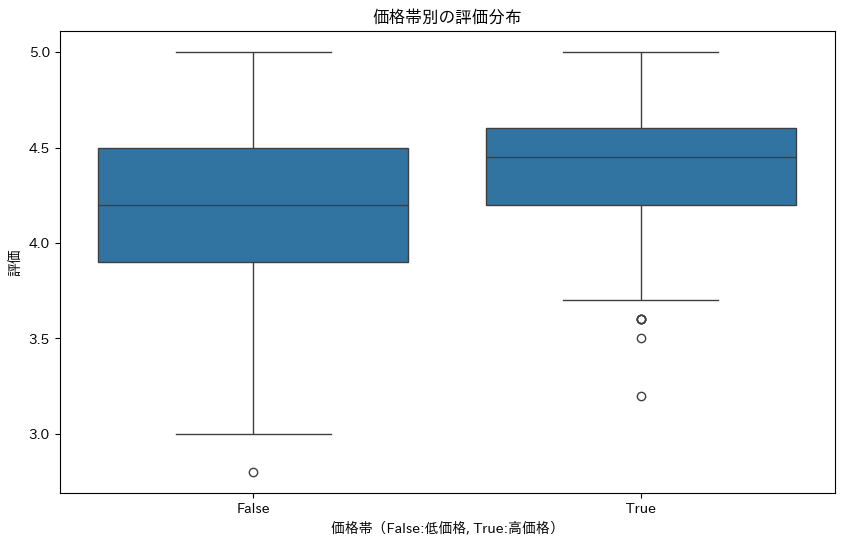

In [22]:
from scipy.stats import mannwhitneyu

# 価格中央値で分割
median_price = df['price'].median()
high_price = df[df['price'] > median_price]['rating']
low_price = df[df['price'] <= median_price]['rating']


# 検定
stat, p_value = mannwhitneyu(high_price, low_price)
print(f"マン・ホイットニーU検定: U={stat:.3f}, p={p_value:.3f}")
if p_value < 0.05:
    print("高価格と低価格の評価に有意差があります。")

# グラフ
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x=df['price'] > median_price, y='rating')
plt.title("価格帯別の評価分布")
plt.xlabel("価格帯（False:低価格, True:高価格）")
plt.ylabel("評価")
plt.show()


#### d. 価格の相関分析

都道府県別 平均価格と平均評価の相関: ピアソン相関 = 0.244, スピアマン相関 = 0.317


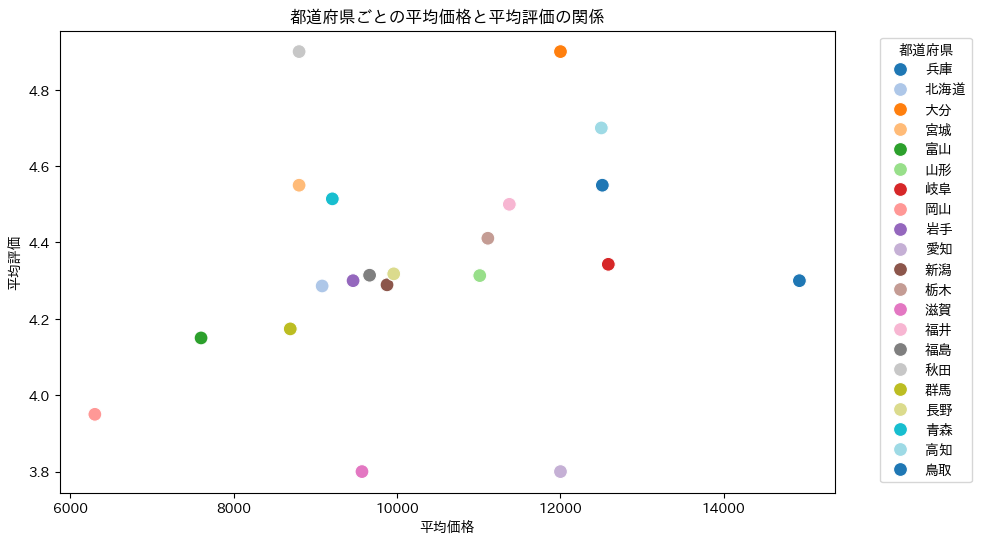

In [24]:
# 都道府県ごとの平均価格と平均評価の相関分析
region_stats = df.groupby('pref')[['price', 'rating']].mean().reset_index()

# pearsonrとspeamanr
from scipy.stats import pearsonr, spearmanr

# 相関分析
pearson_corr, _ = pearsonr(region_stats['price'], region_stats['rating'])
spearman_corr, _ = spearmanr(region_stats['price'], region_stats['rating'])
print(f"都道府県別 平均価格と平均評価の相関: ピアソン相関 = {pearson_corr:.3f}, スピアマン相関 = {spearman_corr:.3f}")

# 散布図のプロット
plt.figure(figsize=(10, 6))
sns.scatterplot(data=region_stats, x='price', y='rating', hue='pref', palette='tab20', s=100)
plt.title("都道府県ごとの平均価格と平均評価の関係")
plt.xlabel("平均価格")
plt.ylabel("平均評価")
plt.legend(title="都道府県", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## 2.評価に基づく分析

#### a. 評価の分布を可視化

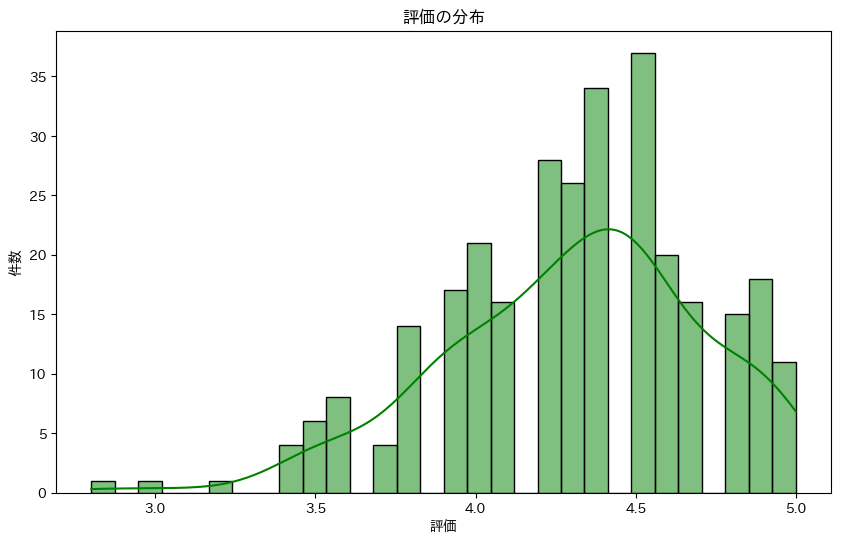

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], kde=True, bins=30, color='green', edgecolor='black')
plt.title("評価の分布")
plt.xlabel("評価")
plt.ylabel("件数")
plt.show()


#### b. 評価の中央値や分布比較

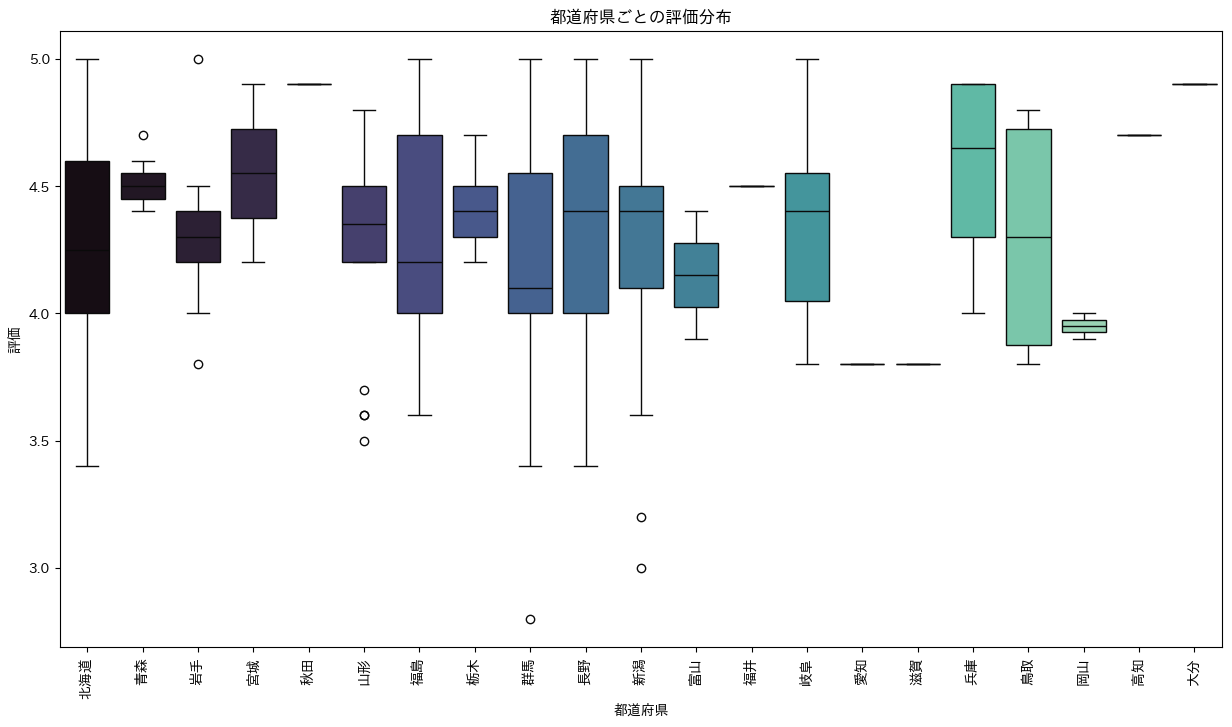

In [26]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=df, x='pref', y='rating', palette='mako')
plt.xticks(rotation=90)
plt.title("都道府県ごとの評価分布")
plt.xlabel("都道府県")
plt.ylabel("評価")
plt.show()


#### c. 高評価施設の特性分析

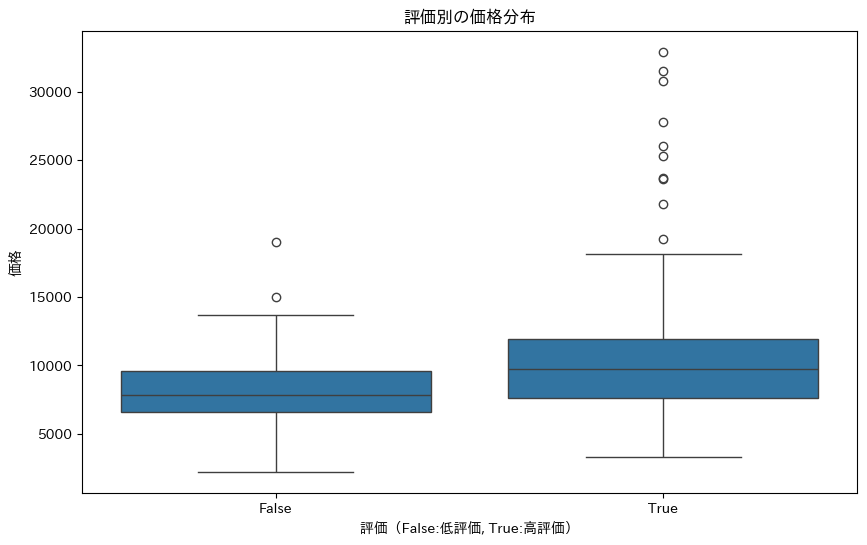

マン・ホイットニーU検定（評価 vs 価格）: U=8872.500, p=0.000
高評価と低評価の価格に有意差があります。


In [31]:
high_rating = df[df['rating'] >= 4.0]['price']
low_rating = df[df['rating'] < 4.0]['price']


plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x=df['rating'] >= 4.0, y='price')
plt.title("評価別の価格分布")
plt.xlabel("評価（False:低評価, True:高評価）")
plt.ylabel("価格")
plt.show()

stat, p_value = mannwhitneyu(high_rating, low_rating)
print(f"マン・ホイットニーU検定（評価 vs 価格）: U={stat:.3f}, p={p_value:.3f}")
if p_value < 0.05:
    print("高評価と低評価の価格に有意差があります。")
else:
    print("高評価と低評価の価格に有意差がありません。")

# 白丸が表すのは、各都道府県の平均価格と平均評価


#### d. 評価と価格の地域差の相関

都道府県別 平均価格と平均評価の相関: ピアソン相関 = 0.244, スピアマン相関 = 0.317


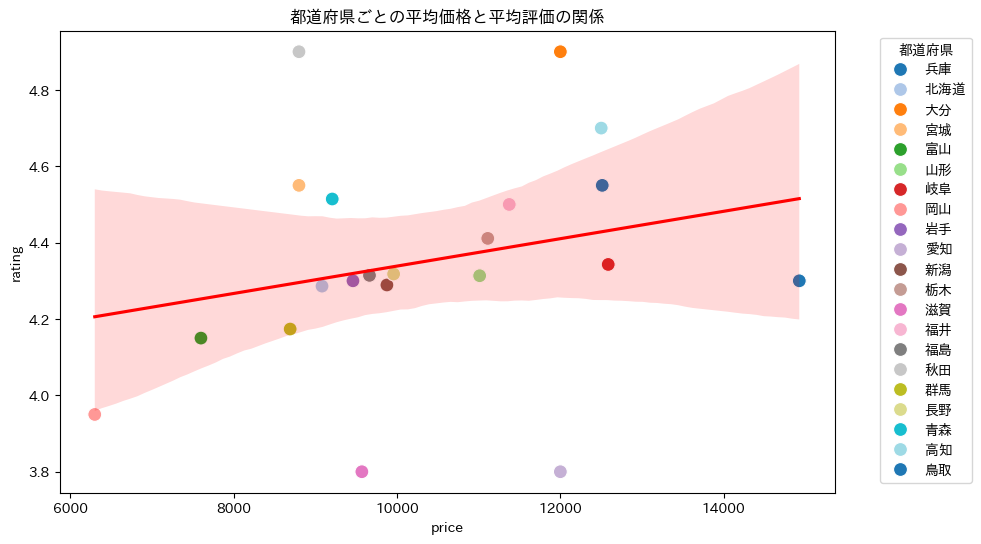

In [34]:
# 都道府県ごとの平均価格と平均評価の相関分析
region_stats = df.groupby('pref')[['price', 'rating']].mean().reset_index()

# 相関分析
pearson_corr, _ = pearsonr(region_stats['price'], region_stats['rating'])
spearman_corr, _ = spearmanr(region_stats['price'], region_stats['rating'])
print(f"都道府県別 平均価格と平均評価の相関: ピアソン相関 = {pearson_corr:.3f}, スピアマン相関 = {spearman_corr:.3f}")

# 散布図のプロット
plt.figure(figsize=(10, 6))
sns.scatterplot(data=region_stats, x='price', y='rating', hue='pref', palette='tab20', s=100)
plt.title("都道府県ごとの平均価格と平均評価の関係")
plt.xlabel("平均価格")
plt.ylabel("平均評価")
plt.legend(title="都道府県", bbox_to_anchor=(1.05, 1), loc='upper left')
# 相関関数の１次関数をプロット
sns.regplot(data=region_stats, x='price', y='rating', scatter=False, color='red')
plt.show()


## 3.都道府県に基づく分析

#### a. 都道府県別の平均値比較

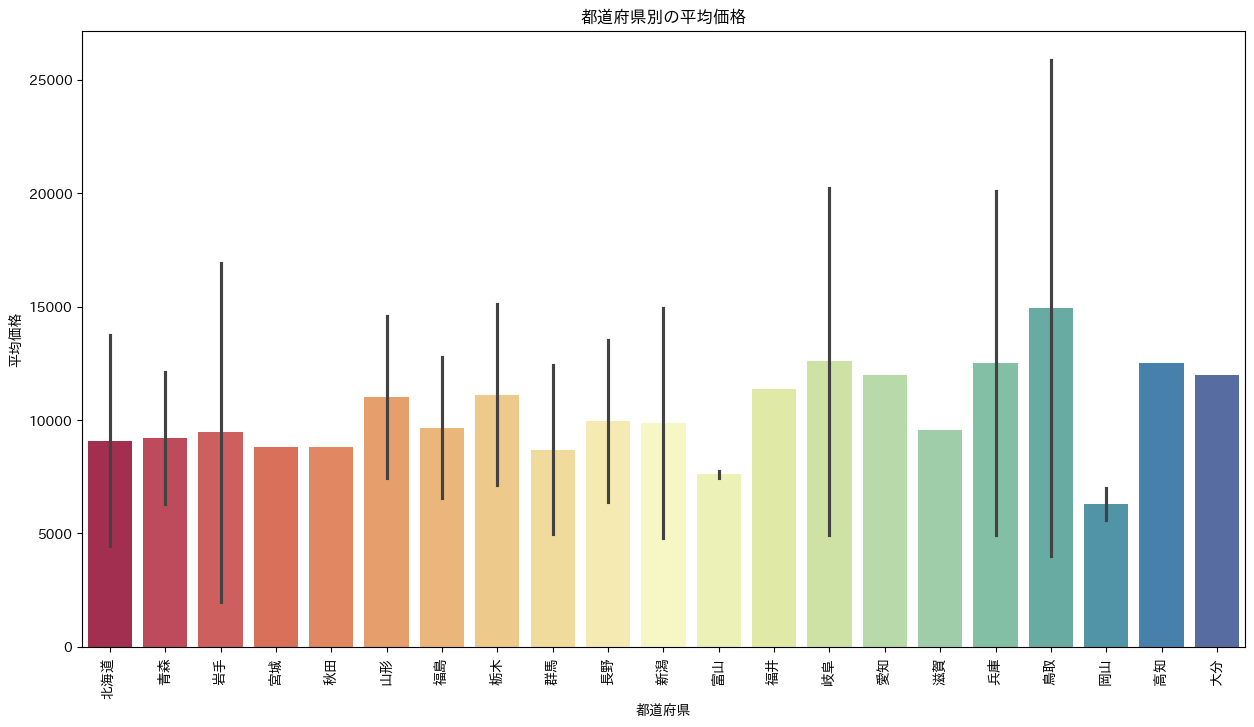

In [35]:
plt.figure(figsize=(15, 8))
sns.barplot(data=df, x='pref', y='price', ci='sd', palette='Spectral') # 黒い線は標準偏差
plt.xticks(rotation=90)
plt.title("都道府県別の平均価格")
plt.xlabel("都道府県")
plt.ylabel("平均価格")
plt.show()


#### b. 地域ごとのクラスター分析

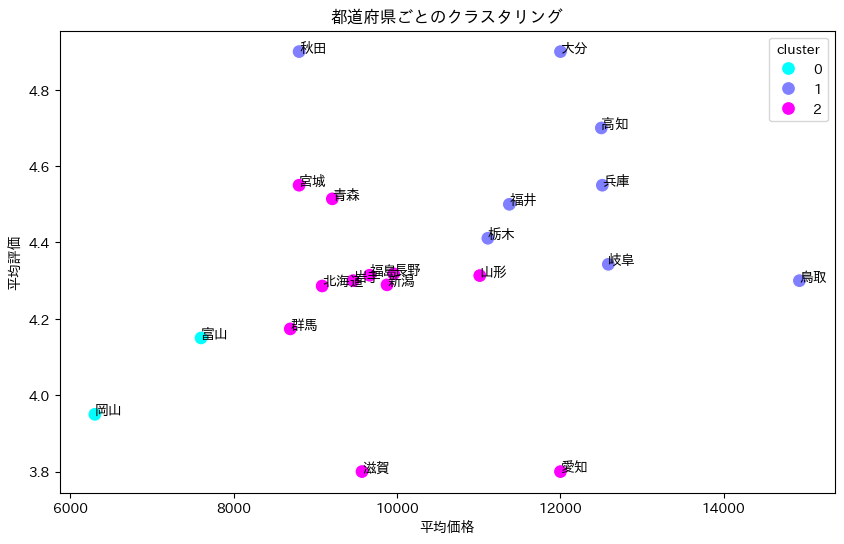

In [36]:
from sklearn.cluster import KMeans
import numpy as np

# クラスタリング用のデータを作成
clustering_data = df.groupby('pref')[['price', 'rating']].mean().reset_index()
clustering_data_scaled = (clustering_data[['price', 'rating']] - np.mean(clustering_data[['price', 'rating']], axis=0)) / np.std(clustering_data[['price', 'rating']], axis=0)

# クラスタリング
kmeans = KMeans(n_clusters=3, random_state=42)
clustering_data['cluster'] = kmeans.fit_predict(clustering_data_scaled)

# クラスタリング結果の可視化
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clustering_data, x='price', y='rating', hue='cluster', palette='cool', s=100)
for i in range(len(clustering_data)):
    plt.text(clustering_data.loc[i, 'price'], clustering_data.loc[i, 'rating'], clustering_data.loc[i, 'pref'])
plt.title("都道府県ごとのクラスタリング")
plt.xlabel("平均価格")
plt.ylabel("平均評価")
plt.show()


#### c. 都道府県ごとの施設数と特徴の分布

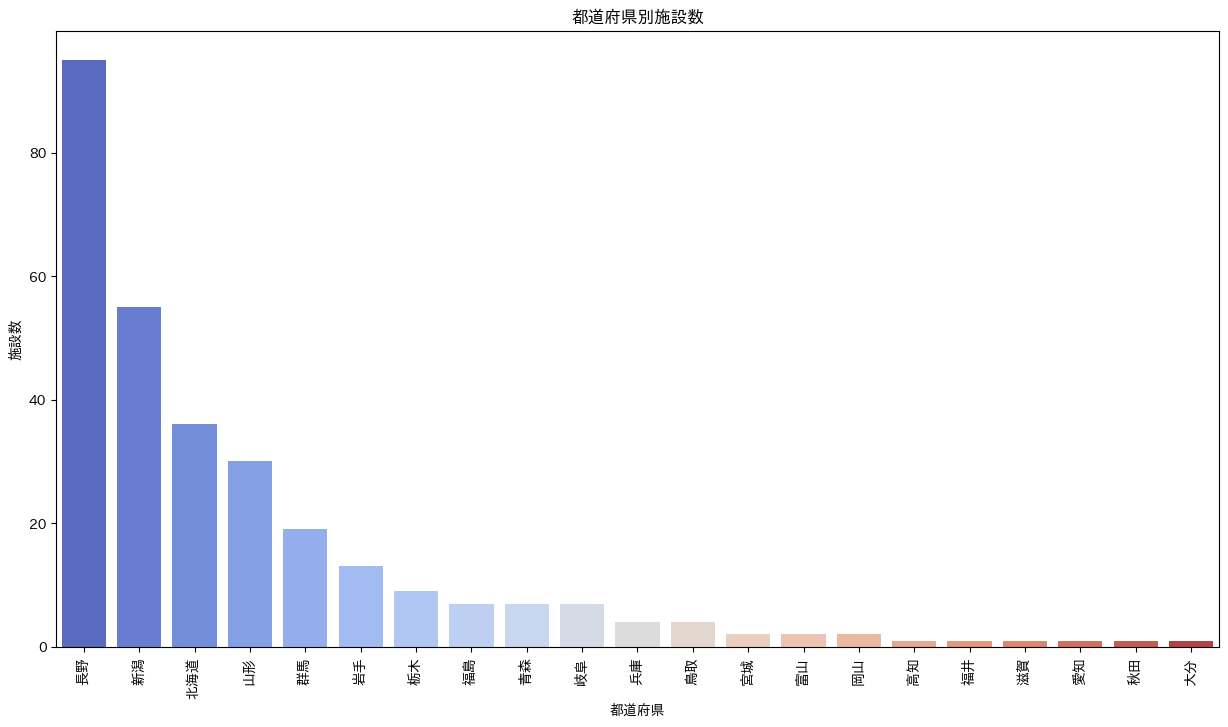

In [37]:
pref_counts = df['pref'].value_counts()
plt.figure(figsize=(15, 8))
sns.barplot(x=pref_counts.index, y=pref_counts.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title("都道府県別施設数")
plt.xlabel("都道府県")
plt.ylabel("施設数")
plt.show()
